In [1]:
import os, sys, pickle
import numpy as np
from copy import deepcopy
from tqdm import tqdm_notebook as tqdm
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path = list(set(sys.path))
import matplotlib.pyplot as plt
%matplotlib inline

from gail.gail import GAILTrainer
from flow.envs import WaveAttenuationMergePOEnv
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder, get_flow_params
import gym, ray
from ray import tune
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.rllib.agents.ppo.ppo_policy_graph import PPOPolicyGraph
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print
from ray.rllib.evaluation.sample_batch import DEFAULT_POLICY_ID

benchmark_name = 'multi_merge'
exp_name = 'latest_gail'
results_list = os.listdir('/headless/ray_results/' + exp_name)
AGENT = 'GAIL' # 'PPO' or 'DDPG' or 'HUMAN'
checkpoint = '120'

benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.gail_flow_params

ray.init(ignore_reinit_error=True)

2019-05-31 05:30:23,821	INFO node.py:469 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-31_05-30-23_43548/logs.
2019-05-31 05:30:24,041	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:49967 to respond...
2019-05-31 05:30:24,311	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:32288 to respond...
2019-05-31 05:30:24,316	INFO services.py:804 -- Starting Redis shard with 10.0 GB max memory.
2019-05-31 05:30:24,529	INFO node.py:483 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-31_05-30-23_43548/logs.
2019-05-31 05:30:24,536	INFO services.py:1427 -- Starting the Plasma object store with 18.23 GB memory using /dev/shm.


{'node_ip_address': '10.138.0.2',
 'object_store_address': '/tmp/ray/session_2019-05-31_05-30-23_43548/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-05-31_05-30-23_43548/sockets/raylet',
 'redis_address': '10.138.0.2:49967',
 'webui_url': None}

In [2]:
GAIL_PATH = 'GAILTrainer_MultiWaveAttenuationMergePOEnvGAIL-v0_3_discrim_lr=0.005_2019-05-31_00-57-4510ppymby'

In [3]:
PATH = ''
if AGENT == 'GAIL':
    PATH = exp_name + '/' + GAIL_PATH
    
config_path = '/headless/rl_project/ray_results/' + PATH + '/params.pkl'
checkpoint_path = '/headless/rl_project/ray_results/' + PATH + '/checkpoint_{}/checkpoint-{}'.format(checkpoint, checkpoint)

with open(config_path, mode='rb') as f:
    config = pickle.load(f)
config["expert_path"] = '/headless/rl_project/flow_codes/InverseRL/expert_sample'
config["num_cpus"] = 2
config["num_rollouts"] = 1
config["num_workers"] = 1
flow_params = get_flow_params(config)
create_env, env_name = make_create_env(params=flow_params, version=0)
env = create_env()
left_length = env.k.scenario.edge_length('left')
car_length = 5.0
scale = 10

# Register as rllib env
register_env(env_name, create_env)

In [5]:
config

{'batch_mode': 'truncate_episodes',
 'callbacks': {'on_episode_end': tune.function(<function on_episode_end at 0x7fdb19406730>),
  'on_episode_start': tune.function(<function on_episode_start at 0x7fdb193cf158>),
  'on_episode_step': tune.function(<function on_episode_step at 0x7fdb194067b8>),
  'on_postprocess_traj': None,
  'on_sample_end': None,
  'on_train_result': None},
 'clip_actions': False,
 'clip_param': 0.3,
 'clip_rewards': None,
 'collect_metrics_timeout': 180,
 'compress_observations': False,
 'custom_resources_per_worker': {},
 'discrim_hidden_size': 128,
 'discrim_lr': 0.005,
 'entropy_coeff': 0.0,
 'env': 'MultiWaveAttenuationMergePOEnvGAIL-v0',
 'env_config': {'flow_params': '{\n    "env": {\n        "additional_params": {\n            "FLOW_RATE": 2000,\n            "FLOW_RATE_MERGE": 100,\n            "RL_PENETRATION": 0.1,\n            "buf_length": 1,\n            "eta1": 1.0,\n            "eta2": 0.1,\n            "eta3": 0.0,\n            "max_accel": 3,\n      

In [6]:
agent = GAILTrainer(config, env_name)

2019-05-31 05:30:48,534	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
2019-05-31 05:30:48,544	INFO json_reader.py:65 -- Found 1 input files.
2019-05-31 05:30:50,156	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
2019-05-31 05:30:57,124	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7fdb18bb4b70>}
2019-05-31 05:30:57,128	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fdb1

In [7]:
agent.restore(checkpoint_path)

In [8]:
render = False
env = None
if render:
    env = make_vis_env(flow_params, MultiWaveAttenuationMergePOEnv, MergeScenario)
else: 
    env = create_env()
    env.init_discriminator(128)

In [9]:
# calculate the space-time velocity map
left_length = env.k.scenario.edge_length('left')
car_length = 5.0
scale = 10
vel_lists = []
vel_map_lists = []
outflow_lists = []

num_iter = 1
for _ in tqdm(range(num_iter)):
    state = env.reset(False)
    vel = []
    outflow = []
    for i in tqdm(range(750)):
        # record the mean velocity
        v = np.mean(env.k.vehicle.get_speed(env.k.vehicle.get_ids()))
        vel.append(v)

        # record the velocity map
        ids = env.k.vehicle.get_ids_by_edge('left')
        vel_map_ = np.zeros(int(left_length)*scale)
        for id_ in ids:
            pos_ = np.round(env.k.vehicle.get_position(id_), decimals=1)
            vel_ = max(env.k.vehicle.get_speed(id_), 0)
            pos_bottom = max(0, int((pos_-car_length/2.0)*scale))
            pos_top = min(int(left_length)*scale, int((pos_+car_length/2.0)*scale))
            vel_map_[pos_bottom:pos_top] = vel_            

        # step the simulation
        rl_ids = env.k.vehicle.get_rl_ids()
        actions = {}
        if AGENT != 'HUMAN':
            for id_ in rl_ids:
                current_edge = env.k.vehicle.get_edge(id_)
                # if 'inflow' in current_edge:
                #     continue
                
                action = agent.compute_action(state[id_], policy_id=DEFAULT_POLICY_ID)
                actions.update({id_: action})
        # actions = agent.compute_action(state)
        state, r, _, _ = env.step(actions)
        outflow.append(env.k.vehicle.get_outflow_rate(600)) # measured by one min

        if i == 0:
            vel_map_list = vel_map_
        else:
            vel_map_list = np.vstack((vel_map_list, vel_map_))

    outflow_lists.append(outflow[-500:])
    vel_lists.append(vel)
    vel_map_list[vel_map_list==0.0] = np.nan
    vel_map_lists.append(vel_map_list)

2019-05-31 05:31:15,748	INFO tf_run_builder.py:89 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.


(pid=44777) Loading configuration... done.
(pid=44777) Success.
(pid=44777) Loading configuration... done.
(pid=44777) 2019-05-31 05:32:03,810	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 1 on CPU (please ignore any CUDA init errors)
(pid=44777) 2019-05-31 05:32:03.812330: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=44777) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=44777)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



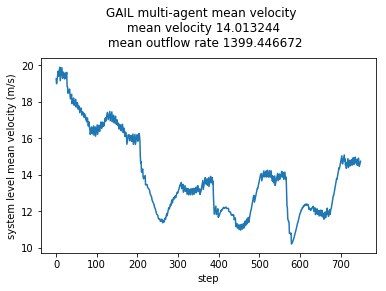

In [10]:
vel_fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(num_iter):
    ax.plot(vel_lists[i])
title = AGENT + ' multi-agent mean velocity'
title = title + ' \n mean velocity {:3f}'.format(np.mean(vel_lists))
title = title + ' \n mean outflow rate {:3f}'.format(np.mean(outflow_lists))
ax.set_ylabel('system level mean velocity (m/s)')
ax.set_xlabel('step')
vel_fig.suptitle(title)
plt.subplots_adjust(top=0.8)

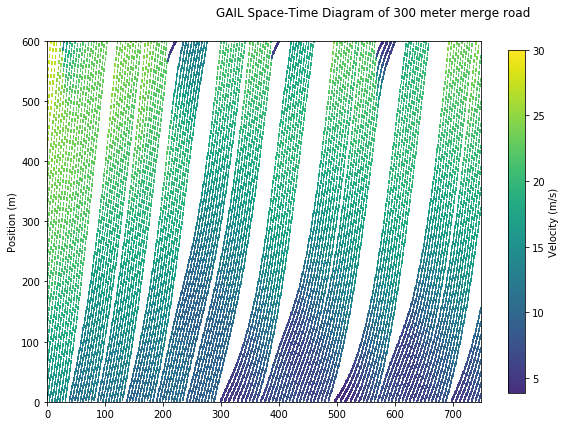

In [11]:
nrows = 1 
ncols = 1
space_fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6))
space_fig.tight_layout()

for i in range(num_iter):
    # plt.subplot(2, 3, i+1)
    x = np.arange(int(750))
    y = np.arange(0, int(left_length), step=0.1)
    xx, yy = np.meshgrid(x, y)
    try:
        im = axes[i%2, i%3].pcolormesh(xx, yy, vel_map_lists[i].T)
        if i % 3 == 0:
            axes[i%2, i%3].set_ylabel('Position (m)')
        if int(i / 3.0) > 0:
            axes[int(i/3), int(i/3)].set_xlabel('step')
    except:
        im = axes.pcolormesh(xx, yy, vel_map_lists[i].T)
        if i % 3 == 0:
            axes.set_ylabel('Position (m)')
        if int(i / 3.0) > 0:
            axes.set_xlabel('step')
        
try:
    clb = space_fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
except:
    clb = space_fig.colorbar(im, ax=axes, shrink=0.95)
    
clb.set_clim(0, 30)
clb.set_label('Velocity (m/s)')
title = AGENT + ' Space-Time Diagram of 300 meter merge road'
space_fig.suptitle(title)   
plt.subplots_adjust(top=0.9, right=0.8)

In [19]:
if not render:
    if AGENT == 'HUMAN':
        filename = 'HUMAN.png'
        vel_dir = '../result/MultiMerge/' + AGENT + '/mean_velocity/'
        space_dir = '../result/MultiMerge/' + AGENT + '/space_time_diagram/'
    else:
        filename = PATH[PATH.find('/') + 1:].replace(' ', '_') + '.png'
        vel_dir = '../result/MultiMerge/' + AGENT + '/' + exp_name + '/mean_velocity/'
        space_dir = '../result/MultiMerge/' + AGENT + '/' + exp_name + '/space_time_diagram/'
    os.makedirs(vel_dir, exist_ok=True)
    os.makedirs(space_dir, exist_ok=True)

    vel_fig.savefig(vel_dir + filename)
    space_fig.savefig(space_dir + filename)